In [1]:
# Preamble
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.decomposition import PCA

## Introduction

Sometimes you want to find out the relations of a given dataset through data visualization.
Well, within 3 features, you can easily plot a 3D graph. How about more than 4 features?
There two common techniques to resolve this problem by reducing feature dimension:

- 1) Feature Selection:  Select a subset of the most important features
- 2) Feature Extraction: Transforms features into lower dimensional space

"Feature Selection" typically works if the features are perfectly independent to each other, but what if there are hidden relations among the features, how do we go about selecting them?
"Feature Extraction" on the other hand, projects features onto new subspace rather than directly selecting subset from original features.



## Tutorial content

In this tutorial, we'll be focusing on "Feature Extraction" (a.k.a "Dimensionality Reduction"), specifically the classical method - "Principal Component Analysis (PCA)", which is a good starting point. I'll give some of the intuition with data visualization without diving into math, and you'll be learning how to use python librarys to run feature extraction on various datasets.

We will cover the following topics in this tutorial:
- [The classic feature extraction - Principal Component Analysis (PCA)](#The-classic-feature-extraction---Principal-Component-Analysis-(PCA))
- [Intuition behind the scenes](#Intuition-behind-the-scenes)
- [Visualizing PCA with real datasets](#Visualizing-PCA-with-real-datasets)
- [Iris dataset (4-dimension)](#Iris-dataset-(4-dimension))
- [Step 1. Normalization](Step-1.-Normalization)
- [Step 2. Apply PCA](Step-2.-Apply-PCA)
- [Step 3: Analyze variance retained after PCA](#Step-3:-Analyze-variance-retained-after-PCA)
- [Visualizing variance retained](#Visualizing-variance-retained)
- [A rule of thumb of selecting components](#A-rule-of-thumb-of-selecting-components)
- [Visualizing projection onto new subspace](#Visualizing-projection-onto-new-subspace)
- [Primary projection (PC1+PC2) v.s. Secondary projection (PC2+PC3)](#)
- [Labeled Faces in the Wild dataset (2914-dimension)](#Labeled-Faces-in-the-Wild-dataset-(2914---dimension))
- [Conclusion and beyond](#Conclusion-and-beyond)
- [References](#References)

## The classic feature extraction - Principal Component Analysis (PCA)

### Intuition behind the scenes

Let's not worry too much about what feature extraction or PCA really is. Suppose now we have a task to draw a line which best describes any given 2D data points and retain as much characteristic as possible from the original distribution, which line would you draw? 
(Code snippet below will generate 2D scatter plot)

#### Task 1: Draw a line representing the distribution

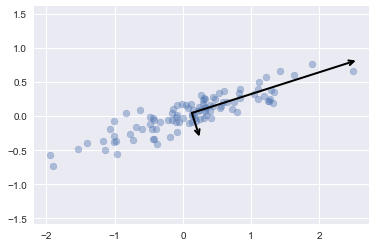

In [2]:
# Generate 2D data
rng = np.random.RandomState(1)
X = np.dot(rng.rand(2, 2), rng.randn(2, 100)).T

# Apply PCA (don't worry too much yet)
pca = PCA(n_components=2)
pca.fit(X)

# Plot 2D data + 2 line arrows
def draw_vector(vec0, vec1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->', linewidth=2, shrinkA=0, shrinkB=0)
    ax.annotate('', vec1, vec0, arrowprops=arrowprops)

plt.scatter(X[:, 0], X[:, 1], alpha=0.4)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

#### Task 2: Count the most points on 2D plane

Most likely we're going to choose the one that stretches to the upper right, since it looks more like the original distribution. Still don't get it? Let's view this in another way. Imagine you are standing on the same plane with this 2D scatter plot, now you are told to count the number of points from where you are standing. Which point might give you the most likely approximation?

- A: (0.5, -1.0), view data points that stretches from bottom left to upper right 
- B: (3.0, 1.0),  view data points that stretches from upper left to bottom right

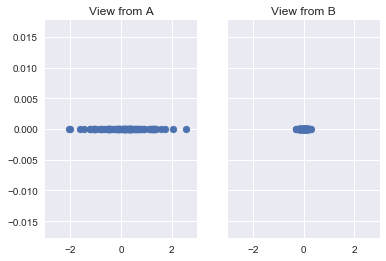

In [3]:
f, (ax1, ax2) = plt.subplots(1, 2,sharey=True)
x_pc1 = X @ np.array(pca.components_[0]) # projection onto first principal component  (PC1)
x_pc2 = X @ np.array(pca.components_[1]) # projection onto second principal component (PC2)
y = np.zeros(X.shape[0])

ax1.set_title('View from A')
ax2.set_title('View from B')
ax1.set_xlim(-3, 3)
ax2.set_xlim(-3, 3)
ax1.scatter(x_pc1, y);
ax2.scatter(x_pc2, y);

Did you see how things are working? If data are viewed from A, namely projected on to the line which presumably best describes the data points, or say retains the largest variance after projection, A seems to be better than B. 

In our 2D example, PCA is all about finding the projection with the largest variance possible, also known as the first principal component (PC1). 
Extending this to n-dimensional dataset, if our target is to extract k features (where k < n), PCA is then about finding the first principal component (PC1), second principal component (PC2), up to k-th principal component (PCk), hence Principal Component Analysis (PCA). These k principal components together span a new subspace, where n-dimensional data gets projected onto this lower k-dimensional subspace, so this is why "feature extraction" is also called "dimensionality reduction".

## Visualizing PCA with real datasets

### Install `plotly` for interacitve visualization

Now, we will be using some datasets to visualize PCA in action!
`plotly` is an interactive and high quality library for plotting, use `pip` to install:

    $ pip install plotly
    

In [4]:
import plotly.plotly
from plotly.graph_objs import *
import plotly.tools as tls

### Iris dataset (4-dimension)

Iris is a classic flower dataset with only 3 species: Setosa, Versicolor, and Virginica, along with 4 features (4-dimension).

In [5]:
from sklearn.datasets import load_iris
import numpy as np
import pandas as pd

In [6]:
# Loading Iris dataset from sklearn
iris = load_iris()
X = iris['data']   # 150 x 4
y = iris['target'] # 150

feature_names   = iris.feature_names
species_names   = iris.target_names
num_of_features = len(feature_names)

print ("X =", X.shape)
print ("y =", y.shape)
print ("Features:", feature_names)
print ("Species:",  species_names)

X = (150, 4)
y = (150,)
Features: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
Species: ['setosa' 'versicolor' 'virginica']


### Species distribution among different features

In [7]:
import plotly.plotly
from plotly.graph_objs import *
import plotly.tools as tls
plotly.offline.init_notebook_mode(connected=True) # Use offline mode

In [8]:
# plot histograms

traces = []
legend = {0:False, 1:False, 2:False, 3:True}
colors = {0: 'rgb(31, 119, 180)', 
          1: 'rgb(255, 127, 14)', 
          2: 'rgb(44, 160, 44)'}

for col in range(4):
    for key in colors:
        traces.append(Histogram(x=X[y==key, col], 
                        opacity=0.75,
                        xaxis='x%s' %(col+1),
                        marker=Marker(color=colors[key]),
                        name=iris.target_names[key],
                        showlegend=legend[col]))

data = Data(traces)

layout = Layout(barmode='overlay',
                xaxis=XAxis(domain=[0, 0.25],     title=iris['feature_names'][0]),
                xaxis2=XAxis(domain=[0.3, 0.5],   title=iris['feature_names'][1]),
                xaxis3=XAxis(domain=[0.55, 0.75], title=iris['feature_names'][2]),
                xaxis4=XAxis(domain=[0.8, 1],     title=iris['feature_names'][3]),
                yaxis=YAxis(title='count'),
                title='Distribution of the different Iris flower features')

fig = Figure(data=data, layout=layout)
plotly.offline.iplot(fig)

The above plot shows the distributions of different species for each features. You might see some features are highly separated, while some appears to be highly overlapped. Let's now use PCA to project Iris data from 4-D space to a 2-D space, and see if we can tell the relations via the result.

### Step 1. Normalization

In [9]:
from sklearn.preprocessing import StandardScaler

In [10]:
X_norm = StandardScaler().fit_transform(X)

### Step 2. Apply PCA

In [11]:
pca = PCA(n_components=len(feature_names))
pca.fit(X_norm)

PCA(copy=True, n_components=4, whiten=False)

### Step 3: Analyze variance retained after PCA

In [12]:
PCs = ['PC%s'%i for i in range(1, num_of_features+1)] # ['PC 1','PC 2','PC 3','PC 4']
var_ret     = pca.explained_variance_ratio_
cum_var_ret = np.cumsum(var_ret)

print ("Principal Component(PC)  : ", PCs)
print ("Variance retained ratio  : ", var_ret)     # [PC1, PC2, PC3, PC4]
print ("Cumulative retained ratio: ", cum_var_ret) # [PC1, PC1+PC2, PC1+..+PC3, PC1+..+PC4]

Principal Component(PC)  :  ['PC1', 'PC2', 'PC3', 'PC4']
Variance retained ratio  :  [ 0.72770452  0.23030523  0.03683832  0.00515193]
Cumulative retained ratio:  [ 0.72770452  0.95800975  0.99484807  1.        ]


### Visualizing variance retained

In [13]:
# plotting out
def plot_var(PCs, var_ret, cum_var_ret):
    trace1 = Bar(x=PCs,
                 y=var_ret,
                 showlegend=False)

    trace2 = Scatter(x=PCs, 
                     y=cum_var_ret,
                     name='cumulative variance retained')

    data = Data([trace1, trace2])

    layout=Layout(
            yaxis=YAxis(title='Variance retained ratio'),
            title='Variance retained with different principal components')

    fig = Figure(data=data, layout=layout)
    plotly.offline.iplot(fig)
    
plot_var(PCs, var_ret, cum_var_ret)

### A rule of thumb of selecting components

From the above analysis, we learned that first & second principcal components (PC1 + PC2) together makes up approximately 96% of the variance. Well, how many components should we select? A common heuristic is to retain 99%, but depending on the application 90% to 98% may be used. In this dataset, 96% of the variance is sufficient to see the effect. 

[REF: Stanford UFLDL Tutorial](http://ufldl.stanford.edu/wiki/index.php/PCA)

Next, let's see how the data will be presented when projecting to our subspace that spans from PC1 and PC2.

### Visualizing projection onto new subspace

In [17]:
def scatter_gen(X_new, traces):
    line   = Line(color='rgba(217, 217, 217, 0.14)', width=0.5)
    marker = Marker(size=12, line=line)
    for i in range(len(species_names)):
        trace = Scatter(x=X_new[y==i,0],
                        y=X_new[y==i,1],
                        mode='markers',
                        name=species_names[i],
                        marker=marker,
                        opacity=0.8)
        traces.append(trace)
        
def scatter_plot(X_new, PCs):
    traces = []
    scatter_gen(X_new, traces)
    data = Data(traces)
    layout = Layout(xaxis=XAxis(title=PCs[0], showline=False),
                    yaxis=YAxis(title=PCs[1], showline=False))
    fig = Figure(data=data, layout=layout)
    plotly.offline.iplot(fig)

### Projecting onto primary principal components (PC1 + PC2)

In [18]:
eig_vecs = pca.components_[:2] # select PC1 & PC2
X_new = X_norm @ np.array(eig_vecs.T)
scatter_plot(X_new, PCs[:2])

### Projecting onto secondary principal components (PC2 + PC3)

In [19]:
eig_vecs = pca.components_[1:3] # select PC2 & PC3
X_new = X_norm @ np.array(eig_vecs.T)
scatter_plot(X_new, PCs[1:3])

### Primary projection (PC1+PC2) v.s. Secondary projection (PC2+PC3)

From the above scatter plots with PC1 and PC2, the data seems to be well spreaded out and same species seems to form cluster. On the other hand, with PC2 and PC3 it seems that different species are overlapping without obvious relations among different species. This observation gives us intuition that data being projected onto primary principal components indeed best describes the "features" of the data. 

### Labeled Faces in the Wild dataset (2914-dimension)

Now let's look at an interesting dataset, collected from the internet of some well-known faces. Each face image is 62 x 47 pixel, which is equivalent of having 2914 features! We won't go into detail analysis as Iris dataset, but just to show you how to play around using PCA.

#### Load dataset

In [20]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60) # this may take a while to download

#### Plot 10 faces

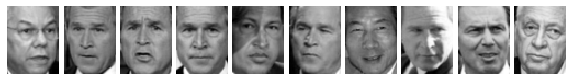

In [21]:
# plot 10 faces
fig, ax = plt.subplots(1, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')

#### Apply PCA

In [22]:
# apply PCA 
pca = PCA(150)
pca.fit(faces.data)

PCA(copy=True, n_components=150, whiten=False)

#### Variance retained analysis

In [23]:
num_of_features = faces.images.shape[1] * faces.images.shape[2]
PCs = ['PC%s'%i for i in range(1, num_of_features+1)] # ['PC 1','PC 2','PC 3','PC 4']
var_ret     = pca.explained_variance_ratio_
cum_var_ret = np.cumsum(var_ret)

plot_var(PCs, var_ret, cum_var_ret)

#### Eigenfaces - Visualizing principal components of an image

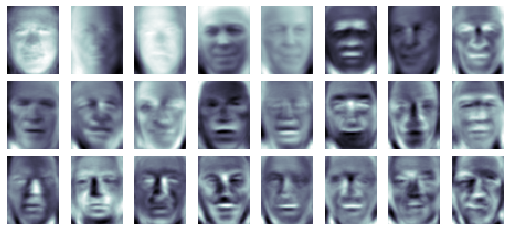

In [24]:
# eigenfaces
fig, axes = plt.subplots(3, 8, figsize=(9, 4),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i, ax in enumerate(axes.flat):
    ax.imshow(pca.components_[i].reshape(62, 47), cmap='bone')

#### Projection and Reconstruction

In [25]:
components = pca.transform(faces.data)         # 1348 x 150
projected  = pca.inverse_transform(components) # 1348 x 2914

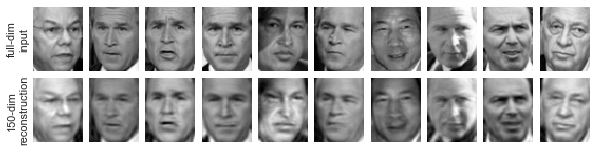

In [26]:
# original image v.s. reconstruction image
fig, ax = plt.subplots(2, 10, figsize=(10, 2.5),
                       subplot_kw={'xticks':[], 'yticks':[]},
                       gridspec_kw=dict(hspace=0.1, wspace=0.1))
for i in range(10):
    ax[0, i].imshow(faces.data[i].reshape(62, 47), cmap='binary_r')
    ax[1, i].imshow(projected[i].reshape(62, 47), cmap='binary_r')
    
ax[0, 0].set_ylabel('full-dim\ninput')
ax[1, 0].set_ylabel('150-dim\nreconstruction');

## Conclusion and beyond

PCA is a simple yet powerful tool especially in Computer Vision field, where it had been used extensively as a dimensionality reduction method. For example, in our face dataset experiment, dimension was successfully reduced from 2914 to 150, while retaining 95% of the variance. One thing worth to mention is that PCA is actually an unsupervised learning method, which does not reference class label to find its principal components, but in some cases the projection gives us a cluster-like distribution among different classes. This leads to some of the interesting research topics in correlating PCA to clustering methods such as k-means. Beyond PCA, there are other extended feature extraction methods, like kernel PCA which does non-linear projection, and LDA which is a supervised version of feature extraction.

## References

- [PCA Wikipedia](https://en.wikipedia.org/wiki/Principal_component_analysis)
- [PCA UFLDL](https://en.wikipedia.org/wiki/Principal_component_analysis)
- [PCA CS229 Lecture](http://cs229.stanford.edu/notes/cs229-notes10.pdf)
- [Scikit-Learn](http://scikit-learn.org/stable/documentation.html)
- [Matplotlib](https://matplotlib.org/)
- [Plotly API Librarys](https://plot.ly/api/)
- [Python Machine Learning](https://pythonmachinelearning.pro/dimensionality-reduction/)
- [Python Data Science Handbook](https://jakevdp.github.io/PythonDataScienceHandbook/05.09-principal-component-analysis.html)